## Topic modeling is All You Need
This notebook aims on covering introduction to methodology and implementation of various topic modeling tools for text mining task. Congressional record data will be used as sample in this notebook.

### Get start with out sample
Before started, we want to load our data and conduct basic cleaning discussed in previous notebooks.</p>

Make sure you have install all libraries before running any 'import" codes.


In [1]:
# import set up
import pandas as pd
import string
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt # for visualization
# remove stop words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tanay\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
fullData = pd.read_csv('test50.csv') # the file you want to topic modeling on
# data preprocessing
# remove punctuation
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)
fullData['speech'] = fullData['speech'].apply(remove_punctuation)

# load and modify our stop word list based on specific goal/ background knowledge
stop_words = set(stopwords.words('english'))
newStop=['much','may','make','even','going','also','would','could'] #add/change stopwords as you needed
for word in newStop:
    stop_words.add(word)
fullData['speech'] = fullData['speech'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

 # make sure we still have some strings for each row after all the cleaning
fullData.dropna(subset=['speech'], inplace=True)

### Statistic topic modeling

#### LDA:Latent Dirichlet allocation
LDA (Latent Dirichlet Allocation) is a unsupervised generative probabilistic model for understanding the content of a text collection. It works on the premise that documents can be considered as combinations of hidden topics, where each topic is defined by a set of words associated with it.</p>
How LDA is used in social science: https://doi.org/10.1007/s11042-018-6894-4 </p>
Model training referrence: https://yanlinc.medium.com/how-to-build-a-lda-topic-model-using-from-text-601cdcbfd3a6</p>
Library reference: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html </p>
ModelShortNote: Quite time-efficient and popular tool in social science. Working fine with topic keywords extraction, but performance poorly for filtering topic-relevant text.

In [ ]:
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

no_features = 150

# LDA
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features) 
tf = tf_vectorizer.fit_transform(fullData['speech']) 
tf_feature_names = tf_vectorizer.get_feature_names_out()

lda = LatentDirichletAllocation(max_iter=5, learning_method='online', learning_offset=50.,random_state=0,n_components=30).fit(tf)

# display LDA result
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        

no_top_words = 10
display_topics(lda, tf_feature_names, no_top_words)
print()

#### NMF: non-negative matrix factorization
NMF (Non-Negative Matrix Factorization) is a matrix factorization technique that rely on linear algebra methods. NMF operates on data transformed using TF-IDF (Term Frequency-Inverse Document Frequency) by splitting a matrix into two lower-ranked matrices. In essence, TF-IDF is a way to assess the importance of words in a set of documents.</p>

Source: https://www.frontiersin.org/articles/10.3389/fsoc.2022.886498/full </p>
Library reference: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html</p>
ModelShortNote: Quiet time-efficient and a bit better on topic stability. Offer fine insights on keyword extraction, but also limited in filtering topic-relevant text.

In [ ]:
# NMF
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features)
tfidf = tfidf_vectorizer.fit_transform(fullData['speech'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

nmf = NMF(n_components=30, random_state=1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Get the NMF result
nmf_components = nmf.components_
# Number of top words to print for each topic
top_n_words = 10
# Loop through each topic
for topic_idx, topic in enumerate(nmf_components):
    # Get the indices of the top N words for the current topic
    top_word_indices = topic.argsort()[-top_n_words:][::-1]
    top_words = [tfidf_feature_names[i] for i in top_word_indices]

    print(f"Topic {topic_idx + 1}:")
    print(", ".join(top_words))
    print()

### Dynamic topic modeling
Dynamic topic modeling(DTM) comprises a set of techniques designed to examine how topics change over time. These approaches provide insights into how a topic is portrayed at various points in time. For instance, the way people discuss environmental awareness in 2000 might vary from how it's discussed in 2010, even though the core topic remains consistent. This difference lies in the specific manner in which the topic is presented.

#### Bertopic modeling: python 3.11
BERTopic allows for DTM by calculating the topic representation at each timestep without the need to run the entire model several times. As the name implies, BERT is harnessed as an embedder and comes equipped with UMAP for dimension reduction and HDBSCAN for document clustering. It also applies a class-based term frequency-inverse document frequency (c-TF-IDF) algorithm to assess term importance within clusters and establish term representations. Notably, BERTopic diverges from LDA by offering continuous, rather than discrete, topic modeling. This inherent stochasticity leads to varying outcomes upon repeated modeling.</p>

 Notably, Topic 0 with a count of −1 will always represent outliers and should not be considered any further. Researchers can also search for a keyword and receive the most important topics based on their similarity score along with the possibility to inspect individual topics based on their keywords. Ultimately, in order to better analyze the potentially large array of topics, BERTopic offers an interactive intertopic distance map for inspecting individual topics.</p>

Documentation: https://maartengr.github.io/BERTopic/api/bertopic.html#bertopic._bertopic.BERTopic </p>


In [ ]:
# you might want to use seperate environment for Bert and sklearn, 
# as they have different version requirement for some common dependencies
from bertopic import BERTopic

# train bert and handle overtime changes
bert_model = BERTopic(verbose=True)
topics, _ = bert_model.fit_transform(fullData['speech'])
topics_over_time = bert_model.topics_over_time(fullData['speech'], fullData['date'], nr_bins=30)
#get some visualization
bert_model.visualize_topics_over_time(topics_over_time, top_n_topics=20)

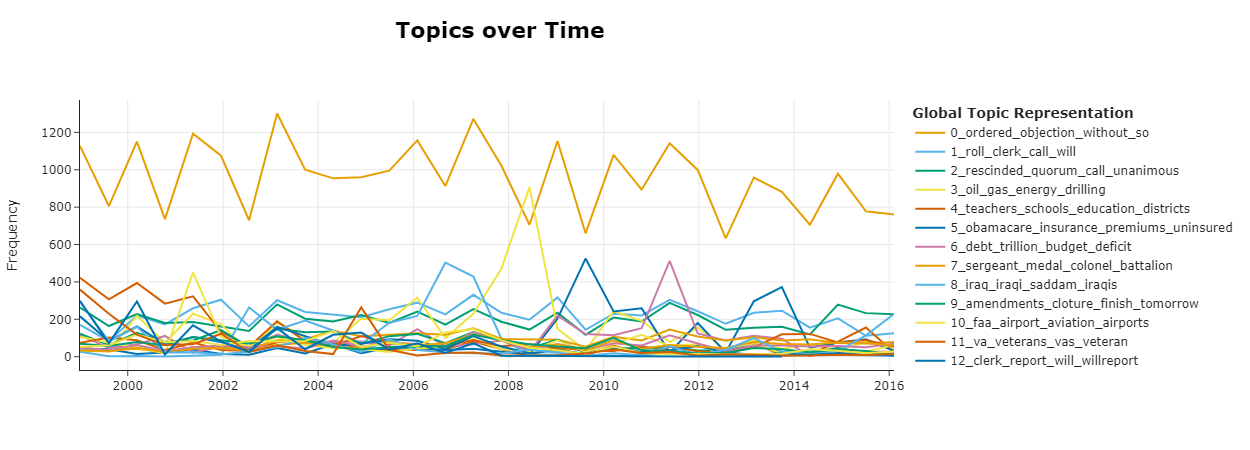

In [1]:
# a sample result you will get from previous steps
from IPython import display
display.Image("Bertopic_50.png")

In [22]:
# save the result for later analysis
topics = bert_model.get_topics()
topics # -1 means outlier and meaningless
import json

with open("data.json", "w") as json_file:
    json.dump(topics, json_file)


In [ ]:
# look for environment related topic
wantET = bert_model.find_topics(search_term='environment')[0]
wantET # display the list of relevant topic
